In [1]:
# encoding=utf8  
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import scipy.interpolate
import scipy.optimize
import sys
import math
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import Divider, Size
#from ipywidgets import interact

def CW(T, C, th): #curie weiss fit
	return C/(T-th)
def CW_lam(T, C, th,lam): #curie weiss fit + constant offset
	return C/(T-th)+lam
def CW_lam_par(T, C, th,lam,C2): #curie weiss fit + constant offset + paramagnetism
	return C/(T-th)+lam+C2/T

In [2]:
def coth(x):
  return 1/np.tanh(x)
def raw_datafile_2_chi(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3])] # sort all data by temperature
    time = data[:,0] #in s
    fields = data[:,2] # in Oe
    T = data[:,3] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field = fields[0] #Oersted
    
    chi = M/field * molar_mass / mass + dia
    chi_err = M_err/field * molar_mass / mass
    return T,chi,chi_err

def raw_datafile_2_chi_ZFC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_ZFC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_ZFC = data_ZFC[np.argsort(data_ZFC[:, 3])] # sort data by temperature
    time = data_ZFC[:,0] #in s
    fields_ZFC = data_ZFC[:,2] # in Oe
    T_ZFC = data_ZFC[:,3] # in K
    M_ZFC = data_ZFC[:,4] # in emu
    M_err_ZFC = data_ZFC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_ZFC = fields_ZFC[0] #Oersted
    
    chi_ZFC = M_ZFC/field_ZFC * molar_mass / mass + dia
    chi_err_ZFC = M_err_ZFC/field_ZFC * molar_mass / mass
    return T_ZFC,chi_ZFC,chi_err_ZFC
    
def raw_datafile_2_chi_FC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_FC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_FC = data_FC[np.argsort(data_FC[:, 3])] # sort data by temperature
    time_FC = data_FC[:,0] #in s
    fields_FC = data_FC[:,2] # in Oe
    T_FC = data_FC[:,3] # in K
    M_FC = data_FC[:,4] # in emu
    M_err_FC = data_FC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_FC = fields_FC[0] #Oersted

    chi_FC = M_FC/field_FC * molar_mass / mass + dia
    chi_err_FC = M_err_FC/field_FC * molar_mass / mass
    return T_FC,chi_FC,chi_err_FC

def raw_datafile_2_AC(data_file,molar_mass,mass):
    import numpy as np
    head_len = 28
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3],kind='stable')] #sort by T
    data = data[np.argsort(data[:, 14],kind='stable')] #sort by freq

    T = data[:,3]
    T = T.round(decimals=1) # to make sure the Temperatures are identical at the same point
    amp = data[:,8] #|m| (emu)
    s_amp = data[:,9]
    phase = data[:,10] #phase of m (deg)
    s_phase = data[:,11]
    reg_fit = data[:,12] #regression fit
    field = 1000 #Oe
    driver = data[0,13] #driver amplitude (Oe)
    freq = data[:,14] #Hz
    freq_list = np.unique(freq)
    T_list = np.unique(T)
    m = data[:,4]/(driver) * molar_mass / mass #m' in emu Oe-1 mol-1
    s_m = data[:,5]/driver * molar_mass / mass #sigma m'in emu Oe-1 mol-1
    md = data[:,6]/driver * molar_mass / mass # m''in emu Oe-1 mol-1
    s_md = data[:,7]/driver * molar_mass / mass #sigma m''in emu Oe-1 mol-1
    return freq,freq_list,T,T_list,m,s_m,md,s_md

def raw_datafile_2_MH(data_file,molar_mass,mass,dia):
    head_len=31
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,0] #in s
    field = data[:,2] # in Oe
    T = data[0,3] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M = M*conv
    BMM = M / muB
    return H,M,BMM

def raw_datafile_2_MH_Maxwell(data_file,molar_mass,mass,dia):
    head_len=34
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,1] #in s
    field = data[:,3] # in Oe
    T = data[0,2] # in K
    M = data[:,16] # in emu
    M_err = data[:,17] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M = M*conv
    BMM = M / muB
    return H,M,BMM

def raw_datafile_2_MH_Maxwell_err(data_file,molar_mass,mass,dia):
    head_len=34
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,1] #in s
    field = data[:,3] # in Oe
    T = data[0,2] # in K
    M = data[:,16] # in emu
    M_err = data[:,17] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M_err = M_err*conv
    BMM_err = M_err / muB
    return H,M_err,BMM_err

def datafile_2_MH(data_file):
    head_len=4
    data = np.genfromtxt(data_file,skip_header=head_len)
    Oe = 1e4
    H =  np.array(data[:,0]) / Oe   

    fh = open(data_file,'r')
    param = np.zeros(head_len)
    for i,line in enumerate(fh):
    	if i is head_len: break
    	param[i]= line
    fh.close()

    molar_mass = param [0] #g mol-1
    mass = param [1]*1e-3 #mg
    dia = param [2]*1e-6 # 1e-6 emu mol-1
    T =  param[3] #K
    muB = 9.27401e-21 * 6.022140e23

    conv =  molar_mass / mass #* 1e-3 / muB
    M = data[:,1]*conv
    BMM = M / muB
    return H,M,BMM

def B_s(S,y): #Brillouin function, diff. to Johnston
    return (2.0*S+1.0)/(2.0*S)*coth((2.0*S+1.0)/(2.0*S)*y)-coth(y/(2.0*S))/(2.0*S)
#y = g_J * muB * J * B  /kT

def lang(y): #Langevin
    return coth(y)-1/y


def mu_lin(T,S,lam,g,y):
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return k_b*T*y/(g*mu_b *S*lam)

def mu0_det(y,T,S,lam,g,Ms):    
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return (B_s(S,y)*Ms-mu_lin(T,S,lam,g,y))**2

def mu0(S,ts):
    out = np.zeros_like(ts)
    i=0
    for t in ts:
        out[i] = scipy.optimize.minimize_scalar(mu0_det,args=(S,t), tol=None, options=None).get('x') #    method='bounded',bounds=(0,1)
        i=i+1
    return out

def brillouin_T(Ts,S,lam,g,Ms): #brillouin function of moment as a function of T
    #S = spin
    #lam = molecular field
    #g = g-value
    #Ms = saturation moment
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    y = np.zeros_like(Ts)
    M_out = np.zeros_like(Ts)
    test = np.zeros_like(Ts)  
    test2 = np.zeros_like(Ts)      
    i=0
    for t in Ts:
        fit = scipy.optimize.minimize(mu0_det,args=(t,S,lam,g,Ms), #method='bounded',bounds=(0,1),
     tol=None, x0=(1000))
        y[i] =fit.get('x') #determine y
        M_out[i] = B_s(S,y[i])*Ms
       # test[i] = (k_b*t*y[i])/(g*mu_b*S*lam)
       # test2[i]  =mu0_det(t,S,lam,g,Ms,y[i])#k_b * t * y[i]/(g*mu_b*S*lam)
        i=i+1       
    return M_out
#def brillouin_T(Ts,S,lam,g,Ms):


In [3]:
#Diamagnetic Contributions

#Sample
molar_mass = 209.6 #g mol-1 #####
mass = 12.3 *1e-3 #mg ####
sample_dia = 101.2*1e-6 # 1e-6 emu mol-1 

#Eicosane
eicosane_molar_mass = 282.55 #g mol-1 ####
eicosane_mass = 10.7 *1e-3 #mg ####
eicosane_molar_dia = 243.06*1e-6 # 1e-6 emu mol-1 

#Diamagnetic contribution of eicosane per mole of CrCl2pym
eicosane_dia = (((eicosane_mass)/eicosane_molar_mass)*eicosane_molar_dia)/(mass/molar_mass)

print(eicosane_dia*1e6)

dia = sample_dia + eicosane_dia # 1e-6 emu mol-1 

156.85130143164815


In [4]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

<IPython.core.display.Javascript object>


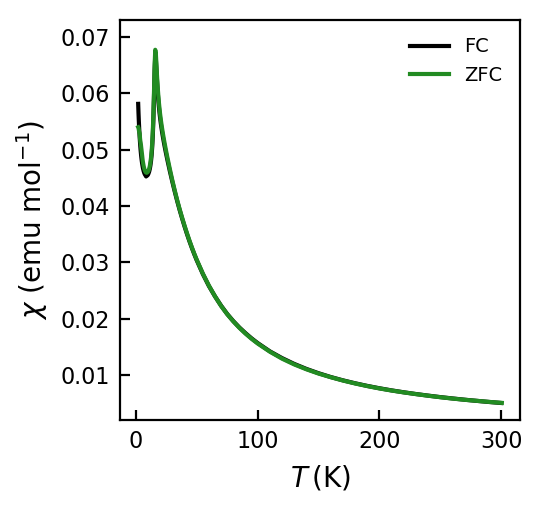

In [5]:
fig = plt.figure(1, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("NiCl2pym_2-300K_FC.rso.dat",molar_mass,mass,dia)
#plt.scatter(T_FC,chi_FC,label='FC', marker="o", edgecolor="black", facecolor='none', s=10)
plt.plot(T_FC,chi_FC,label='FC', color="black", linewidth=1.5,)

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi("NiCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
#plt.scatter(T_ZFC,chi_ZFC,label='ZFC', marker="s", edgecolor="blue", facecolor='none', s=10)
plt.plot(T_ZFC,chi_ZFC,label='ZFC', color="forestgreen", linewidth=1.5,)

plt.legend(shadow=False, loc=1,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$\\chi$ (emu mol$^{-1}$)')
#plt.tight_layout()
#plt.xlim(0,30)
plt.ylim(0.002,0.073)
#plt.savefig('NiCl2pym_qezumo_chi_ZFC_FC.pdf',bbox_inches='tight', transparent=True)

plt.show()

<IPython.core.display.Javascript object>


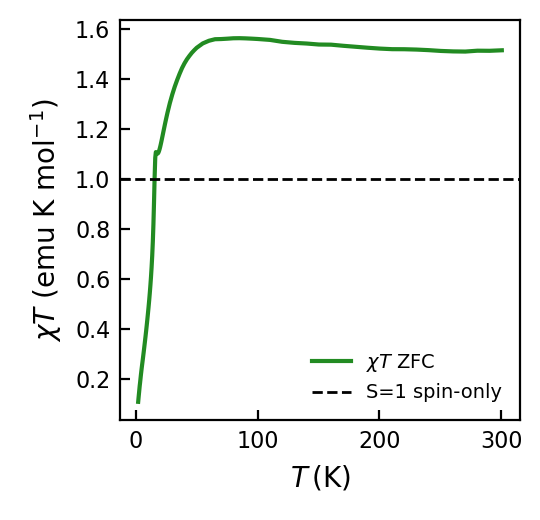

In [6]:
fig = plt.figure(3, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi_ZFC("NiCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
plt.plot(T_ZFC,chi_ZFC*T_ZFC, c="forestgreen", label='$\\chi T$ ZFC')

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("NiCl2pym_2-300K_FC.rso.dat",molar_mass,mass,dia)
#plt.scatter(T_FC,chi_FC*T_FC,marker="s", c="white", edgecolor="black", s=30,label='$\\chi T$ FC')

#plt.xlim(0,300)
#plt.ylim(0,3)
plt.axhline(1,0,1, label="S=1 spin-only", color='k', lw=1, ls='dashed')
#plt.hlines(2.25,0,300, label="Cr(III) + pym$^\u2022$$^–$ Weak AFM")
#plt.hlines(1,0,300, label="Cr(III) + pym$^\u2022$$^–$ Strong AFM", color='red')

plt.legend(shadow=False, loc="lower right",frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$\\chi T$ (emu K mol$^{-1}$)')
#plt.tight_layout()
#plt.savefig('Cr(pym)Cl$_2$_chiT.png',dpi=750)
#plt.savefig('NiCl2pym_qezumo_chiT.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [7]:
chiT_hi = 1.7 #high temperature value of chiT, i.e. S(S+1)/2
mueff = (chiT_hi*8)**0.5 #the mu_eff moment should be just gsqrt(S(S+1)) by spin only approximation and high temperature assumption that Curie law is obeyed
print(mueff) # significnatly reduced value

2*(1*2)**0.5

3.687817782917155


2.8284271247461903

93 259.6001
[ 1.44899787 11.31785061]
[[ 2.68740694e-05 -4.93807215e-03]
 [-4.93807215e-03  9.09434335e-01]]
C 1.4489978678333986 ( 0.005184020582313197 )
BM 3.4047001252191342 ( 0.20364715725613647 )
Weiss T 11.317850612666902 ( 0.9536426662033213 )
g 2.4070108752465145 ( 0.004305732325813303 )


<IPython.core.display.Javascript object>


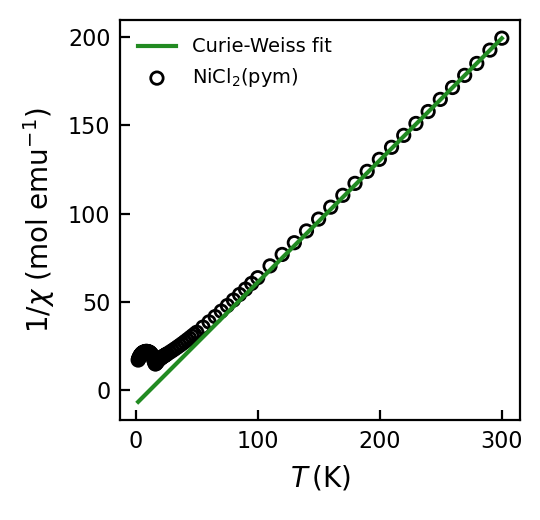

1.4489978678333986 11.317850612666902


In [8]:
#Curie Weiss fitting 
T,chi,chi_err=raw_datafile_2_chi("NiCl2pym_2-300K_FC.rso.dat",molar_mass,mass,dia)
start = np.argmax(T>250) #this number here determines where the CW fit starts
print (start,T[start])

p0 = (3,-60)

popt, pcov = scipy.optimize.curve_fit(CW, T[start:], chi[start:],sigma=chi_err[start:],p0=p0)
print (popt)
print (pcov)
print ('C', (popt[0]),'(',pcov[0,0]**0.5,')')
print ('BM', (popt[0]*8)**0.5,'(',(8*pcov[0,0]**0.5)**0.5,')')
print ('Weiss T', (popt[1]),'(',pcov[1,1]**0.5,')')

J=1
mu_0 = 1.256637062*1e-6
mu_b = 9.274010*1e-21
k_b = 1.38064852*1e-16
N_a = 6.0221409*1e+23
C=popt[0]

g = np.sqrt(C*(3*k_b)/(N_a*mu_b*mu_b*J*(J+1)))
g_err = g*0.5*(pcov[0,0]**0.5)/C
print("g",g,'(',g_err,')')
#1/chi plot
fig = plt.figure(4, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
T_range = np.arange(0.01,300,0.01)

m, c = np.polyfit(T, 1/CW(T,*popt), 1)

x=np.arange(-60,305,5)

plt.plot(T, 1/CW(T,*popt), color='forestgreen', label='Curie-Weiss fit')


plt.scatter(T,1.0/(chi),label='NiCl$_2$(pym)', marker="o", edgecolor="black", facecolor='none', s=20)

plt.legend(shadow=False, loc=2,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('1/$\\chi$ (mol emu$^{-1}$)')

#plt.savefig('NiCl2pym_qezumo_Curie-Weiss_fit_ZFC.pdf',bbox_inches='tight', transparent=True)

plt.show()

print(*popt)

<IPython.core.display.Javascript object>


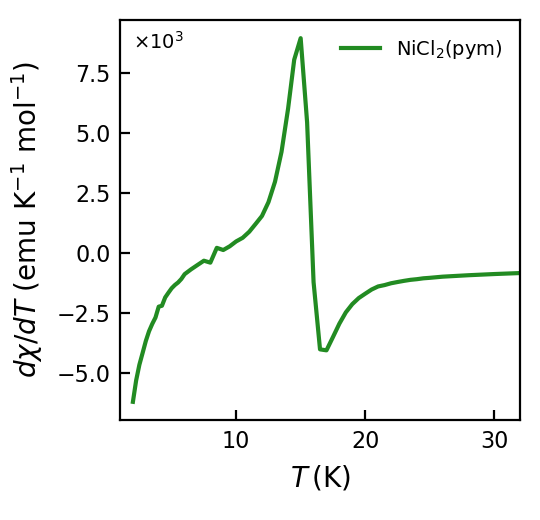

[ 0.00805189  0.00894861  0.00544095 -0.00121249] [15.00123 15.50125 16.0014  16.50134]
TN 16.410233640030732
TN_err 6.174695490517956e-06


In [9]:
fig = plt.figure(21, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

dXdT=(chi[1:]-chi[:-1])/(T[1:]-T[:-1])
Td=T[1:]
start = np.argmax(Td>14.9)
finish = np.argmax(Td>16.6)
print(dXdT[start:finish], Td[start:finish])
f = scipy.interpolate.interp1d(dXdT[start:finish], Td[start:finish])
#print(len(H2K))
#print(BMM2K[55:70])
print("TN",f(0))

f_err = scipy.interpolate.interp1d(dXdT[start:finish], chi_err[start:finish])
print("TN_err",f_err(0))

T_range = np.arange(0.01,300,0.01)
plt.plot(T[:-1],(chi[1:]-chi[:-1])/(T[1:]-T[:-1])*1e3,color='forestgreen',label='NiCl$_2$(pym)')#, s=4)
#plt.ylim(-2.7,0.8)
plt.xlim(1,32)
#plt.hlines(0.82,0,300)

ax1.text(2, 8.5,"$\\times 10^{3}$",fontsize=7)

plt.legend(shadow=False, loc=1,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$d \\chi /dT$ (emu K$^{-1}$ mol$^{-1}$)')

plt.show()

#plt.savefig('dXdT-NiClpym_ZFC.pdf',bbox_inches='tight', transparent=True)

In [11]:
#Diamagnetic Contributions

#Sample
molar_mass = 209.6#g mol-1 #####
mass_Cav = 17.2 *1e-3 #g ####
sample_dia_Cav = 101.2*1e-6 # emu mol-1 

#Eicosane
cling_molar_mass = 32 #g mol-1 ####
cling_mass = 7.3 *1e-3 #mg ####
cling_molar_dia = 17.86*1e-6 # emu mol-1 

#Diamagnetic contribution of eicosane per mole of sample
cling_dia = (((cling_mass)/cling_molar_mass)*cling_molar_dia)/(mass_Cav/molar_mass)

dia_Cav = sample_dia + cling_dia # 1e-6 emu mol-1 

<IPython.core.display.Javascript object>


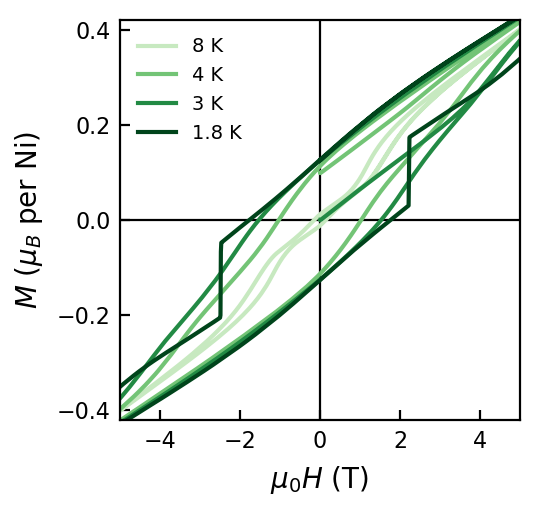

[ 0.00739113 -0.00256016]
Mrem 0.1265012937738048 2.4601233729305177e-05
Hc -1.771337890625 -0.000310639160812816 -0.010459472656249913


In [12]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)

fig = plt.figure(6, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

H2K,M2K_err,BMM2K_err = raw_datafile_2_MH_Maxwell_err("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)


plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

plt.axvline(0,0,1,  color='k', lw=0.8)
plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

print(H2K[2839:2841])
f = scipy.interpolate.interp1d(H2K[2839:2841], BMM2K[2839:2841])
#print('Mrem',BMM2K[2840],BMM2K_err[2840])
print('Mrem',f(0),BMM2K_err[2840])
print("Hc",H2K[3013],BMM2K[3013],H2K[3013]-H2K[3012])

#ax1.plot(H16K,BMM16K,color=cmap(2/6),label='16K')
#ax1.plot(H32K,BMM32K,color=cmap(1/6),label='32K')
ax1.plot(H8K,BMM8K,color=cmap(1/4),label='8 K')
ax1.plot(H4K,BMM4K,color=cmap(2/4),label='4 K')
ax1.plot(H3K,BMM3K,color=cmap(3/4),label='3 K')
ax1.plot(H2K,BMM2K,color=cmap(4/4),label='1.8 K')

ax1.legend(frameon=False,loc=2)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Ni)')

ax1.set_xlim(-5,5)
ax1.set_ylim(-0.42,0.42)
#plt.savefig('MH_NiCl2pym_qezumo_14T_zoom.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('MH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


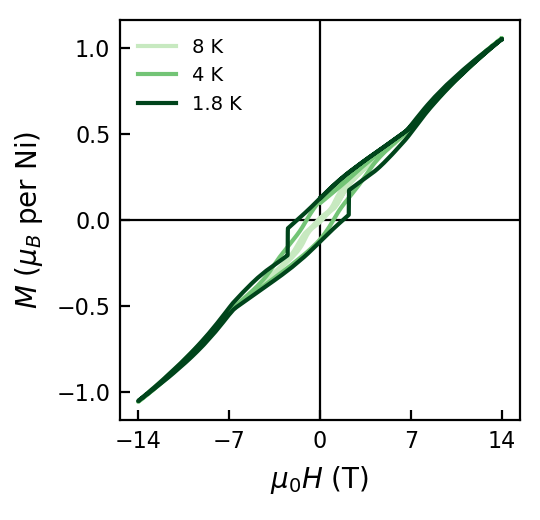

[ 0.00739113 -0.00256016]
Mrem 0.1265012937738048 2.4601233729305177e-05
Hc -1.771337890625 -0.000310639160812816 -0.010459472656249913


In [14]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)


fig = plt.figure(7, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

H2K,M2K_err,BMM2K_err = raw_datafile_2_MH_Maxwell_err("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)


plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

plt.axvline(0,0,1,  color='k', lw=0.8)
plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

print(H2K[2839:2841])
f = scipy.interpolate.interp1d(H2K[2839:2841], BMM2K[2839:2841])
#print('Mrem',BMM2K[2840],BMM2K_err[2840])
print('Mrem',f(0),BMM2K_err[2840])
print("Hc",H2K[3013],BMM2K[3013],H2K[3013]-H2K[3012])

finish = 1500

#ax1.plot(H16K,BMM16K,color=cmap(2/6),label='16K')
#ax1.plot(H32K,BMM32K,color=cmap(1/6),label='32K')
ax1.plot(H8K,BMM8K,color=cmap(1/4),label='8 K')
ax1.plot(H4K,BMM4K,color=cmap(2/4),label='4 K')
#ax1.plot(H3K,BMM3K,color=cmap(3/4),label='3 K')
ax1.plot(H2K,BMM2K,color=cmap(4/4),label='1.8 K')

ax1.legend(frameon=False,loc=2)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Ni)')
ax1.set_xticks([-14,-7,0,7,14])

#plt.savefig('MH_NiCl2pym_qezumo_14T_zoom.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('MH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


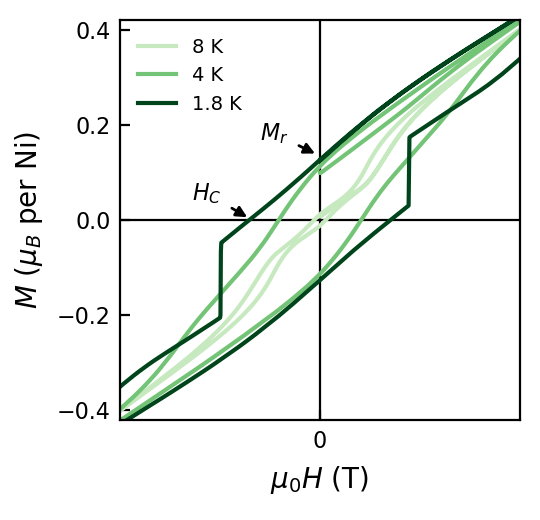

[ 0.00739113 -0.00256016]
Mrem 0.1265012937738048 2.4601233729305177e-05
Hc -1.771337890625 -0.000310639160812816 -0.010459472656249913


In [16]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)


fig = plt.figure(71, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

H2K,M2K_err,BMM2K_err = raw_datafile_2_MH_Maxwell_err("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)


plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

plt.axvline(0,0,1,  color='k', lw=0.8)
plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

print(H2K[2839:2841])
f = scipy.interpolate.interp1d(H2K[2839:2841], BMM2K[2839:2841])
#print('Mrem',BMM2K[2840],BMM2K_err[2840])
print('Mrem',f(0),BMM2K_err[2840])
print("Hc",H2K[3013],BMM2K[3013],H2K[3013]-H2K[3012])

finish = 1500

#ax1.plot(H16K,BMM16K,color=cmap(2/6),label='16K')
#ax1.plot(H32K,BMM32K,color=cmap(1/6),label='32K')
ax1.plot(H8K,BMM8K,color=cmap(1/4),label='8 K')
ax1.plot(H4K,BMM4K,color=cmap(2/4),label='4 K')
#ax1.plot(H3K,BMM3K,color=cmap(3/4),label='3 K')
ax1.plot(H2K,BMM2K,color=cmap(4/4),label='1.8 K')

ax1.legend(frameon=False,loc=2)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Ni)')
ax1.set_xticks([-14,-7,0,7,14])

ax1.annotate("$M_r$", (0.5,0.66), xytext=(0.35,0.7), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)
ax1.annotate("$H_C$", (0.33,0.5), xytext=(0.18,0.55), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)

ax1.set_xlim(-5,5)
ax1.set_ylim(-0.42,0.42)
#plt.savefig('MH_NiCl2pym_qezumo_14T_zoom.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('MH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


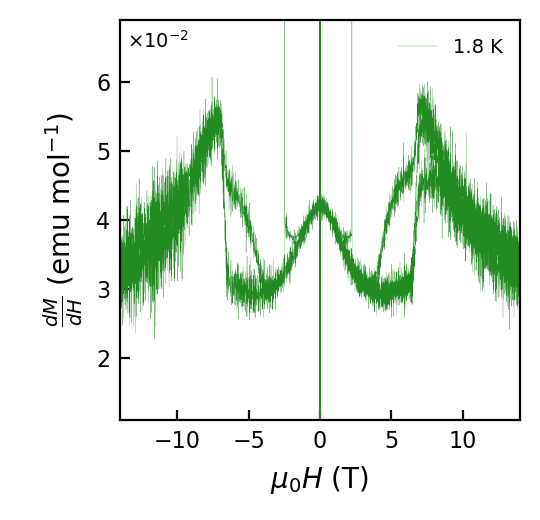

In [17]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)


fig = plt.figure(8, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

#plt.axvline(0,0,1,  color='k', lw=0.8)
#plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

dM2K = M2K[1:]-M2K[:-1]
dH2K = H2K[1:]-H2K[:-1]

dM2K=ma.masked_where(dH2K==0,dM2K)
dH2K=ma.masked_where(dH2K==0,dH2K)

dM8K = M8K[1:]-M8K[:-1]
dH8K = H8K[1:]-H8K[:-1]

dM8K=ma.masked_where(dH8K==0,dM8K)
dH8K=ma.masked_where(dH8K==0,dH8K)

ax1.text(-13.5, 6.5,"$\\times 10^{-2}$",fontsize=7)

ax1.plot(H2K[:-1],1e-2*dM2K/dH2K,color='forestgreen',label='1.8 K', lw=0.1)
#ax1.plot(H8K[:-1],1e-2*dM8K/dH8K,color='forestgreen',label='8 K', lw=0.1)

ax1.legend(frameon=False,loc=1)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$\\frac{dM}{dH}$ (emu mol$^{-1}$)')

ax1.set_xlim(-14,14)
ax1.set_ylim(1.1,6.9)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T_zoom.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


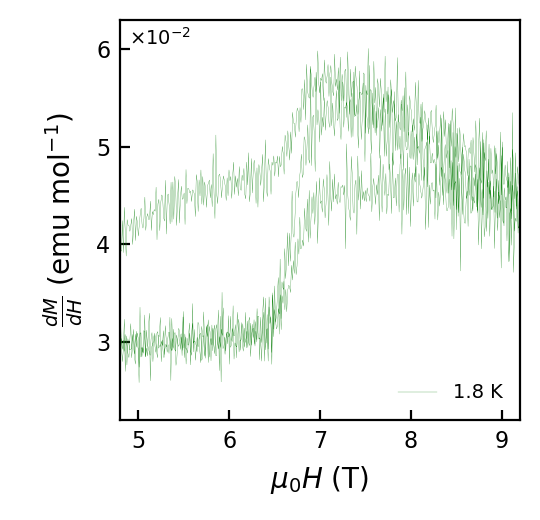

In [18]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)

fig = plt.figure(9, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")


color=cmap(1/6)

dM2K = M2K[1:]-M2K[:-1]
dH2K = H2K[1:]-H2K[:-1]

dM2K=ma.masked_where(dH2K==0,dM2K)
dH2K=ma.masked_where(dH2K==0,dH2K)

ax1.text(4.9, 6.05,"$\\times 10^{-2}$",fontsize=7)

ax1.plot(H2K[:-1],1e-2*dM2K/dH2K,color='forestgreen',label='1.8 K', lw=0.1)

ax1.legend(frameon=False,loc=4)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$\\frac{dM}{dH}$ (emu mol$^{-1}$)')

ax1.set_xlim(4.8,9.2)
ax1.set_ylim(2.2,6.3)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T_zoom.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


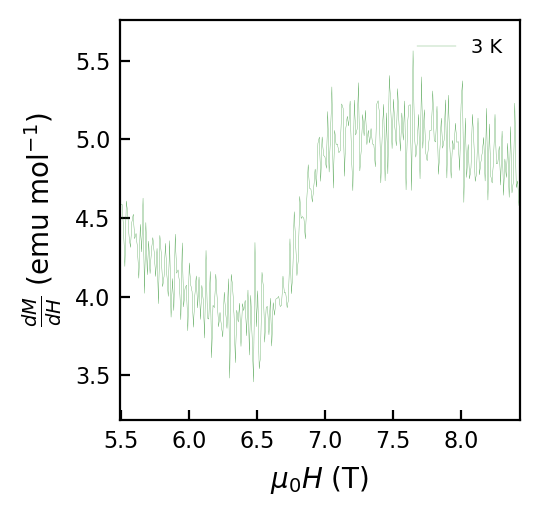

In [21]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)

fig = plt.figure(10, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

#plt.axvline(0,0,1,  color='k', lw=0.8)
#plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

dM2K = M2K[1:]-M2K[:-1]
dH2K = H2K[1:]-H2K[:-1]

dM2K=ma.masked_where(dH2K==0,dM2K)
dH2K=ma.masked_where(dH2K==0,dH2K)

dM3K = M3K[1:]-M3K[:-1]
dH3K = H3K[1:]-H3K[:-1]

dM3K=ma.masked_where(dH3K==0,dM3K)
dH3K=ma.masked_where(dH3K==0,dH3K)

dM8K = M8K[1:]-M8K[:-1]
dH8K = H8K[1:]-H8K[:-1]

dM8K=ma.masked_where(dH8K==0,dM8K)
dH8K=ma.masked_where(dH8K==0,dH8K)

ax1.text(0.2, 7.7,"$\\times 10^{-2}$",fontsize=7)

finish=1400

#ax1.plot(H2K[:-1],1e-2*dM2K/dH2K,color='forestgreen',label='1.8 K', lw=0.1)
ax1.plot(H3K[:finish],1e-2*dM3K[:finish]/dH3K[:finish],color='forestgreen',label='3 K', lw=0.1)
#ax1.plot(H8K[:-1],1e-2*dM8K/dH8K,color='forestgreen',label='8 K', lw=0.1)

ax1.legend(frameon=False,loc=1)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$\\frac{dM}{dH}$ (emu mol$^{-1}$)')

ax1.set_xlim(0,14)
ax1.set_ylim(2.8,7.99)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T_initial_sweep.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


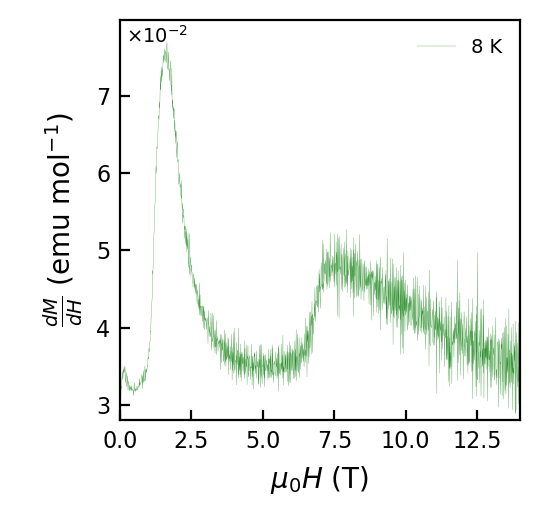

In [11]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)

fig = plt.figure(11, figsize=(2.7, 2.6))
h = [Size.Fixed(0.6), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

color=cmap(1/6)

dM2K = M2K[1:]-M2K[:-1]
dH2K = H2K[1:]-H2K[:-1]

dM2K=ma.masked_where(dH2K==0,dM2K)
dH2K=ma.masked_where(dH2K==0,dH2K)

dM3K = M3K[1:]-M3K[:-1]
dH3K = H3K[1:]-H3K[:-1]

dM3K=ma.masked_where(dH3K==0,dM3K)
dH3K=ma.masked_where(dH3K==0,dH3K)

dM8K = M8K[1:]-M8K[:-1]
dH8K = H8K[1:]-H8K[:-1]

dM8K=ma.masked_where(dH8K==0,dM8K)
dH8K=ma.masked_where(dH8K==0,dH8K)

ax1.text(0.2, 7.7,"$\\times 10^{-2}$",fontsize=7)

finish=1400

ax1.plot(H8K[:finish],1e-2*dM8K[:finish]/dH8K[:finish],color='forestgreen',label='8 K', lw=0.1)

ax1.legend(frameon=False,loc=1)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$\\frac{dM}{dH}$ (emu mol$^{-1}$)')

ax1.set_xlim(0,14)
ax1.set_ylim(2.8,7.99)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T_initial_sweep_8K.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


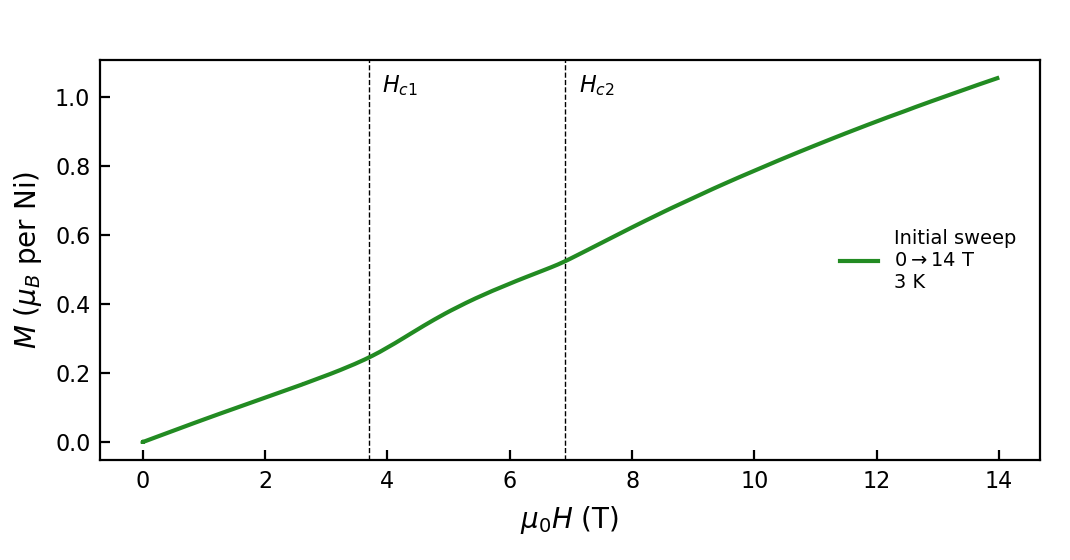

In [19]:
H2K,M2K,BMM2K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_1p8K_14T.dat",molar_mass,mass_Cav,dia)
H3K,M3K,BMM3K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_3K_14T.dat",molar_mass,mass_Cav,dia)
H4K,M4K,BMM4K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_4K_14T.dat",molar_mass,mass_Cav,dia)
H8K,M8K,BMM8K = raw_datafile_2_MH_Maxwell("NiCl2pym_MvH_8K_14T.dat",molar_mass,mass_Cav,dia)

fig = plt.figure(12, figsize=(5.35,2.8))
h = [Size.Fixed(0.5), Size.Fixed(4.7)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
cmap = plt.get_cmap('Greens')

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

#plt.axvline(0,0,1,  color='k', lw=0.8)
#plt.axhline(0,0,1,  color='k', lw=0.8)

color=cmap(1/6)

dM2K = M2K[1:]-M2K[:-1]
dH2K = H2K[1:]-H2K[:-1]

dM2K=ma.masked_where(dH2K==0,dM2K)
dH2K=ma.masked_where(dH2K==0,dH2K)

dM3K = M3K[1:]-M3K[:-1]
dH3K = H3K[1:]-H3K[:-1]

dM3K=ma.masked_where(dH3K==0,dM3K)
dH3K=ma.masked_where(dH3K==0,dH3K)

dM8K = M8K[1:]-M8K[:-1]
dH8K = H8K[1:]-H8K[:-1]

dM8K=ma.masked_where(dH8K==0,dM8K)
dH8K=ma.masked_where(dH8K==0,dH8K)

ax1.text(0.2, 7.7,"$\\times 10^{-2}$",fontsize=7)

finish=1400

plt.axvline(3.7,zorder=0,c="k", ls="--",lw=0.5)
plt.axvline(6.9,zorder=0,c="k", ls="--",lw=0.5)

ax1.annotate("$H_{c1}$", (0.3,0.92), xytext=None, xycoords='axes fraction', arrowprops=None,fontsize=8)
ax1.annotate("$H_{c2}$", (0.51,0.92), xytext=None, xycoords='axes fraction', arrowprops=None,fontsize=8)


ax1.plot(H3K[:finish],BMM3K[:finish],color='forestgreen',label='Initial sweep \n$0\\rightarrow 14$ T\n3 K')

ax1.legend(frameon=False,loc=7)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Ni)')

#ax1.set_xlim(0,14)
#ax1.set_ylim(2.8,7.99)
#plt.savefig('MH_NiCl2pym_qezumo_phase_diagram.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_NiCl2pym_qezumo_14T.pdf',bbox_inches='tight', transparent=True)
plt.show()
